In [44]:
# Requires GenePattern Notebook: pip install genepattern-notebook
import gp
import genepattern

# Username and password removed for security reasons.
genepattern.display(genepattern.session.register("https://cloud.genepattern.org/gp", "", ""))

GPAuthWidget()

##  Create Cells Mask

Note that a value of ~1 means that pixel belongs to the mask and it is rendered as white.
A value of 0 means it deos not belong the mask and it is rendered as black.


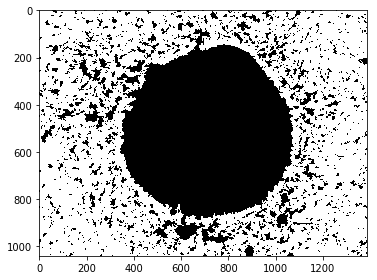

In [6]:
# Mostly from here: https://www.learnopencv.com/filling-holes-in-an-image-using-opencv-python-c/
%matplotlib inline
import cv2
import numpy as np
from skimage import draw
from skimage import io

 
# Read image
im_in = cv2.imread("analyses/MDA231_stopper_1_c3.tif", cv2.IMREAD_GRAYSCALE);
 
# Threshold.
# Set values equal to or above 20 to 0.
# Set values below 20 to 255.
 
th, im_th = cv2.threshold(im_in, 20, 255, cv2.THRESH_BINARY_INV);
 
# Copy the thresholded image.
im_floodfill = im_th.copy()
 
# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
 
# Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255);
 
# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
 
# Combine the two images to get the foreground.
im_out = im_th | im_floodfill_inv
io.imsave(fname='temp_output.png', arr=im_out)

# im_out_inv = cv2.bitwise_not(im_out)


# dilate the mask:
k_size = 2
k_half = k_size/2
kernel = np.ones((k_size,k_size),np.uint8)
coords = draw.circle(k_half, k_half, k_half, shape=im_th.shape)
kernel[coords] = 1 
erosion = cv2.erode(im_out,kernel,iterations = 1)
dilation = cv2.dilate(cv2.bitwise_not(erosion),kernel,iterations = 1)
# cells_mask = cv2.bitwise_not(dilation)
cells_mask = dilation/255


io.imshow(cells_mask)
print("Note that a value of ~1 means that pixel belongs to the mask and it is rendered as white.")
print("A value of 0 means it deos not belong the mask and it is rendered as black.")
# io.imsave(fname='mask.png', arr=dilation)

## cost functions

### Attempt 0

In [13]:
import matplotlib.pyplot as plt
filename = 'analyses/MDA231_stopper_1_c3.tif'


In [14]:
image = io.imread(filename,as_grey=True)
im2 = image>0.2
im2 = im2.astype(int)

x_opt = 691.25591905
y_opt = 529.27572426

/opt/conda/envs/python3.6/lib/python3.6/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


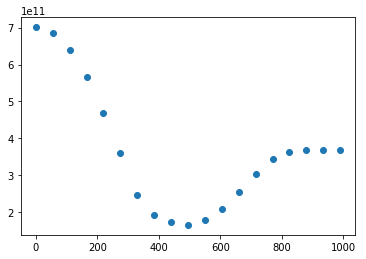

In [19]:
def cost(params):
    image = im2
    x0= params[0]
    y0 = params[1]
    r = params[2]
    coords = draw.circle(y0, x0, r, shape=image.shape)
    template = np.zeros_like(image) #set all values to be zero
    template[coords] = 1 
    penalty = 1
#     score = np.sum(template) - penalty*(len(template)- np.sum(template))
#     print('%g\t\t%g' % (2*np.pi*r*r, np.sum(template == image)**2))
    score = 2*np.pi*r*r - penalty*(np.sum(template == image)**2 - 2*np.pi*r*r)  
    return -score


import matplotlib.pyplot as plt
x = [i for i in np.arange(0,1000,55)]
y = [cost([x_opt,y_opt,i]) for i in x]
plt.scatter(x,y)

### optimize

In [28]:
from skimage import io, color, measure, draw, img_as_bool
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

In [26]:
maxy, maxx = image.shape
minx, miny = (0,0)
maxr = max(maxx,maxy)/2

In [20]:
x0 = im2.shape[1]/2
y0 = im2.shape[0]/2
r0 = im2.shape[1]/4

In [47]:
@genepattern.build_ui
def cost(params):
    image = im2
    x0= params[0]
    y0 = params[1]
    r = params[2]
    coords = draw.circle(y0, x0, r, shape=image.shape)
    template = np.zeros_like(image) #set all values to be zero
    template[coords] = 1 
    
    # values outside of the box should be penalized too
    if (x0+r >maxx) or (y0+r>maxy) or (x0-r <0) or (y0-r <0):
        return +1e20
    
    penalty = 100000
    score = 2*np.pi*r*r - penalty*(np.sum(template == image)**2 - 2*np.pi*r*r)  
    return -score

UIBuilder(function_import='cost', name='cost', params=[{'name': 'params', 'label': 'params', 'optional': False…

In [38]:
bnds = ((0, maxx), (0, maxy), (0,2*maxr))
res = optimize.minimize(cost, x0=[x0, y0,x0/2], bounds=bnds)
res

      fun: 1.6555641415451186e+16
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.e+00,  0.e+00, -4.e+08])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 160
      nit: 1
   status: 2
  success: False
        x: array([694.00000171, 520.00000128, 347.00000256])

[694.0000017084234, 520.0000012800867, 347.0000025626351]


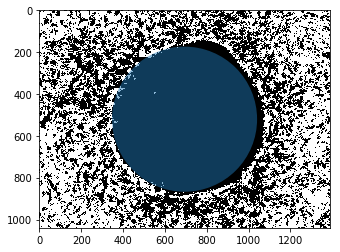

In [39]:
x_opt = res.x[0]
y_opt = res.x[1]
r_opt = res.x[2]
print([x_opt,y_opt,r_opt])
f, ax = plt.subplots()
circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
ax.imshow(im2, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
plt.show()